# Predicting Song Artist  
The overall purpose of this project is to scrape song lyrics from www.lyricsfreak.com, perform cluster anaylsis, nlp anaylsis, and train a variety of models to predict the correct artist from the given lyrics

**Analytical Questions:**
<br>
1.How well can the model predict a particular artist given their song lyrics?
<br>
2.Will the choice of model make an impact?

In [390]:
#Necessary Packages 
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from time import sleep
import urllib.request
import pandas as pd
import numpy as np
import re
import spacy
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
#Function to open page link and get all links on page
def scrapeSongLinks(url):
    page = urllib.request.urlopen(url)
    soup = BeautifulSoup(page, "html.parser")
    links = soup.find_all('a', href=True)
    return links

In [228]:
#Scraper Function
def getSongLyrics():
    base_url = "https://www.lyricsfreak.com"
    artist_urls = ["https://www.lyricsfreak.com/b/beyonce/",
                  "https://www.lyricsfreak.com/c/coldplay/",
                  "https://www.lyricsfreak.com/r/rihanna/",
                  "https://www.lyricsfreak.com/d/demi+lovato//",
                  "https://www.lyricsfreak.com/k/kanye+west/",
                  "https://www.lyricsfreak.com/k/katy+perry/",
                  "https://www.lyricsfreak.com/d/drake/",
                  "https://www.lyricsfreak.com/t/taylor+swift/",
                  "https://www.lyricsfreak.com/b/bruno+mars/",
                  "https://www.lyricsfreak.com/m/michael+jackson/"]
    lyrics = []
    for artist_url in artist_urls:
        split = artist_url.split("/")
        artist = split[4] 
        links = scrapeSongLinks(artist_url)
        artist_links = []
        artist_lyrics = []
        for link in links:
            if artist in str(link):
                link = str(link).strip('<a href="')
                x = link.split('"')
                link = x[0]
                artist_links.append(link)
        artist_links.pop(0)
        for i in range(20):
            song = base_url + artist_links[i]
            songpage = urllib.request.urlopen(song)
            songsoup = BeautifulSoup(songpage, "html.parser")
            for row in songsoup.select('div[id^=content]'):
                artist_lyrics.append(row.text)
        artist_lyrics.remove('')
        lyrics.append(artist_lyrics)
        sleep(5)
    return lyrics

In [229]:
#Run the function
lyrics = getSongLyrics()

In [232]:
#Assign each lyric list to the proper artist
coldplay = lyrics[0]
rihanna = lyrics[1]
demi = lyrics[2]
taylor = lyrics[3]
michael = lyrics[4]

In [245]:
#Cleaning
coldplay = [re.sub(r"(?<=\w)([A-Z])", r" \1", word) for word in coldplay]
rihanna = [re.sub(r"(?<=\w)([A-Z])", r" \1", word) for word in rihanna]
demi = [re.sub(r"(?<=\w)([A-Z])", r" \1", word) for word in demi]
taylor = [re.sub(r"(?<=\w)([A-Z])", r" \1", word) for word in taylor]
michael = [re.sub(r"(?<=\w)([A-Z])", r" \1", word) for word in michael]

coldplay = list(filter(None, coldplay))
rihanna = list(filter(None, rihanna))
demi = list(filter(None, demi))
taylor = list(filter(None, taylor))
michael = list(filter(None, michael))

In [268]:
#NLP processing
nlp = spacy.load('en')
coldplay_doc = [nlp(lyric) for lyric in coldplay]
rihanna_doc = [nlp(lyric) for lyric in rihanna]
demi_doc = [nlp(lyric) for lyric in demi]
taylor_doc = [nlp(lyric) for lyric in taylor]
michael_doc = [nlp(lyric) for lyric in michael]

In [255]:
song_docs = [coldplay_doc, rihanna_doc, demi_doc, taylor_doc, michael_doc]

In [311]:
def lemma_frequencies(text, include_stop=True):
    lemma = []
    for i in range(len(text)):
        for token in text[i]:
            if not token.is_punct and (not token.is_stop or include_stop):
                lemma.append(token.lemma_.lower())
    return Counter(lemma)

In [340]:
#Create dataframe
rihanna_sents = [[song, "rihanna"] for song in rihanna_doc]
coldplay_sents = [[song, "coldplay"] for song in coldplay_doc]
taylor_sents = [[song, "taylor"] for song in rihanna_doc]
demi_sents = [[song, "demi"] for song in demi_doc]
michael_sents = [[song, "michael"] for song in michael_doc]
sentences = pd.DataFrame(rihanna_sents + coldplay_sents + taylor_sents + demi_sents + michael_sents)

In [359]:
def bag_of_words(text):
    for i in range(len(text)):
        for token in text[i]:
            allwords = [token.lemma_ for token in text[i] if not token.is_punct and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(10)]

In [360]:
#Word bagging
rihanna_words = bag_of_words(rihanna_doc)
coldplay_words = bag_of_words(coldplay_doc)
taylor_words = bag_of_words(taylor_doc)
demi_words = bag_of_words(demi_doc)
michael_words = bag_of_words(michael_doc)

In [361]:
rihanna_words.remove("-PRON-")
coldplay_words.remove("-PRON-")
taylor_words.remove("-PRON-")
demi_words.remove("-PRON-")
michael_words.remove("-PRON-")

In [370]:
common_words = set(rihanna_words + coldplay_words + taylor_words + demi_words + michael_words)

In [363]:
def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        for word in words:
            df.loc[i, word] += 1
            
    return df

In [364]:
#Count each word from common words and put into the dataframe
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90


,search,srudyng,hear,arm,lift,time,lose,all,way,like,...,control,baby,celebration'cause,day,heart,remote,not,strong,text_sentence,text_source
0,0,0,0,0,0,1,0,0,0,15,...,0,0,0,0,0,0,2,0,"(Some, girls, play, the, game, They, all, walk...",rihanna
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,"(Mc, ,, Nicki, ,, Riri, After, Party, Turn, on...",rihanna
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,"([, Chorus]Breathe, out, ,, breathe, in, Ameri...",rihanna
3,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,"(You, 're, my, sunrise, My, baby, brown, eyes,...",rihanna
4,0,0,0,0,0,0,0,2,0,1,...,0,0,0,0,0,0,2,0,"(I, guess, they, know, I, 'm, baaaaad, ,, baaa...",rihanna


In [398]:
#Random Forest model
rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.8533333333333334

Test set score: 0.4


In [399]:
#Logistic regression model
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(75, 42) (75,)
Training set score: 0.7066666666666667

Test set score: 0.24


In [400]:
# Gradient Boost
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.8533333333333334

Test set score: 0.24


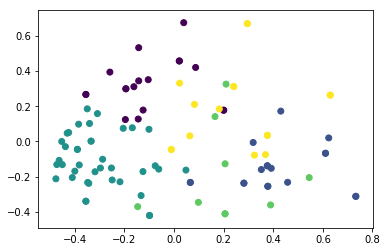

Comparing k-means clusters against the data:
text_source  coldplay  demi  michael  rihanna  taylor
row_0                                                
0                   1     6        3        4       4
1                   3     0        3        6       6
2                  11     9       11        4       4
3                   0     4        3        1       1
4                   5     1        0        5       5


In [380]:
#Clustering
X_norm = normalize(X)

X_pca = PCA(5).fit_transform(X_norm)

y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

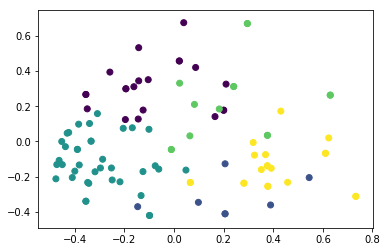

text_source  coldplay  demi  michael  rihanna  taylor
row_0                                                
0                   2     8        3        4       4
1                   0     2        3        1       1
2                  10     9       11        4       4
3                   3     1        0        5       5
4                   5     0        3        6       6


In [382]:
#Clustering with minibatch kmeans
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=5,
    batch_size=100)
minibatchkmeans.fit(X_pca)

predict_mini = minibatchkmeans.predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_mini)
plt.show()

print(pd.crosstab(predict_mini, Y))

In [401]:
#Neural Network model
mlp = MLPClassifier(hidden_layer_sizes=(1000,1000,1000))
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 1000, 1000), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [402]:
mlp.score(X_test, y_test)

0.24

# In Conclusion:
The models created here do not give a good prediction of artist when given lyrics from a song. This may be due to the combination of writers that usually collaberate to create a song. All the models performed about the same so choice of model didn't really matter.